In [1]:
import numpy as np
import sys, os
cwd_split = os.getcwd().split(os.sep)
root = os.path.abspath("")
sys.path.insert(0, f"{root}/build/python")

import mitsuba as mi
# mi.set_variant("cuda_ad_rgb")
mi.set_variant('llvm_ad_rgb')
import drjit as dr
import matplotlib.pyplot as plt
def plot_list(images, title=None):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 3))
    for i in range(len(images)):
        axs[i].imshow(mi.util.convert_to_bitmap(images[i]))
        axs[i].axis('off')
    if title is not None:
        plt.suptitle(title)

from gaussnewton_test import conjugate_gradient, AlbedoScene

In [2]:
scene = mi.load_file('./tutorials/scenes/cbox.xml', res=128, integrator='prb')
image_ref = mi.render(scene, spp=512)

params = mi.traverse(scene)
print(params['light.emitter.radiance.value'])
print(params['red.reflectance.value'])

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

[[18.386999130249023, 13.987299919128418, 6.753570079803467]]
[[0.5700680017471313, 0.043013498187065125, 0.04437059909105301]]


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [3]:
color_sample = dr.linspace(mi.Float, 0, 1, 8)
radiance_sample = dr.linspace(mi.Float, 0, 30, 8)
print(color_sample)

params = mi.traverse(scene)
print(type(params['light.emitter.radiance.value']))
params_line = mi.traverse(scene)

key = 'red.reflectance.value'
keys = ['red.reflectance.value', 'light.emitter.radiance.value'] #'green.reflectance.value', 
# param_ref = mi.Color3f(params[key])
# Set another color value and update the scene
# params[key] = mi.Color3f(0.01, 0.2, 0.9)
# params.update();

# TODO
param_ref = []
# Save the original value
for i in range(len(keys)):
    param_ref.append(mi.Color3f(params[keys[i]]))

# for key in keys:
#     params[key] = mi.Color3f(0.01, 0.2, 0.9)
params[keys[0]] = mi.Color3f(0.01, 0.2, 0.9)
params[keys[1]] = mi.Color3f(30, 3, 3)

params.update();

image_init = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init)

[0.0, 0.14285714285714285, 0.2857142857142857, 0.42857142857142855, 0.5714285714285714, 0.7142857142857142, 0.8571428571428571, 1.0]
<class 'mitsuba.cuda_ad_rgb_double.Color3f'>


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [4]:
# opt = mi.ad.Adam(lr=0.05)
# opt[key] = params[key]
# params.update(opt);



keys_opt = {'red.reflectance.value', 'light.emitter.radiance.value'} #'green.reflectance.value', 
experiment_idx = -2
sc = AlbedoScene(scene, params,  keys_opt, ref_images = image_ref, _EXP_IDX = experiment_idx)

iteration_count = 10
error_grid = []
num_iter_converge = []

for i in range(64):
    id_color_b = i//8
    id_radiance_r = i%8
    # base = i - id_color_g * 64
    # id_color_b = base//16
    # base -= id_color_b * 16
    # id_radiance_r = base//4
    # base -= id_radiance_r
    # id_radiance_g = base%4
    params[keys[0]] = mi.Color3f(0.01, 0.2, color_sample[id_color_b])
    params[keys[1]] = mi.Color3f(radiance_sample[id_radiance_r], 3, 3)

    params.update();
    
    errors = []
    err_ref_init = dr.sum(dr.sqr(param_ref[0] - params[keys[0]] + param_ref[1] - params[keys[1]]))
    print(f"Test {i:02d}: Initialization parameter error = {err_ref_init[0]:6f}")
    errors.append(err_ref_init)
    stop_it = iteration_count

    image, loss = sc.eval_func()
    for it in range(iteration_count):
        
        descent_dir = conjugate_gradient(sc.values(), loss, sc)
        
        sc.step(descent_dir)
        
        image, loss = sc.eval_func()
        
        # Track the difference between the current color and the true value
        err_ref = dr.sum(dr.sqr(param_ref[0] - params[keys[0]] + param_ref[1] - params[keys[1]]))
        if err_ref[0] < 1e-3:
            num_iter_converge.append(it)
            stop_it = it
            break
        elif it == iteration_count - 1:
            num_iter_converge.append(it)
        print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
        errors.append(err_ref)
        
    # num_iter_converge.append(iteration_count)
    print('\nOptimization complete.')

    #image_final = mi.render(scene, spp=128)
    #print(params[keys[0]])
    #print(params[keys[1]])
    #mi.util.convert_to_bitmap(image_final)
    error_grid.append(errors[stop_it])
print(error_grid)
print(num_iter_converge)

Test 00: Initialization parameter error = 490.711395
Iteration 09: parameter error = 0.01292424
Optimization complete.
Test 01: Initialization parameter error = 346.675309
Iteration 09: parameter error = 0.0013167
Optimization complete.
Test 02: Initialization parameter error = 239.373918
Iteration 09: parameter error = 0.0044943
Optimization complete.
Test 03: Initialization parameter error = 168.807220
Iteration 09: parameter error = 0.0054765
Optimization complete.
Test 04: Initialization parameter error = 134.975216
Iteration 09: parameter error = 0.0079904
Optimization complete.
Test 05: Initialization parameter error = 137.877906
Iteration 09: parameter error = 0.0039518
Optimization complete.
Test 06: Initialization parameter error = 177.515289
Iteration 09: parameter error = 0.0039007
Optimization complete.
Test 07: Initialization parameter error = 253.887367
Iteration 09: parameter error = 0.0085759
Optimization complete.
Test 08: Initialization parameter error = 489.646677
It

[0.06522991519985732]
[0.057443125797378806]


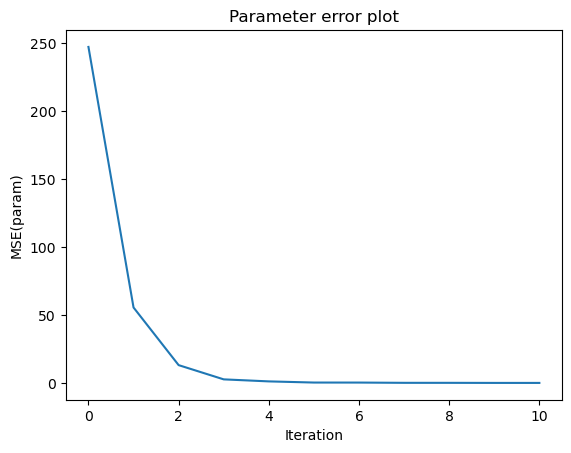

In [5]:
import matplotlib.pyplot as plt
print(errors[iteration_count - 1])
print(dr.min(errors))
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()

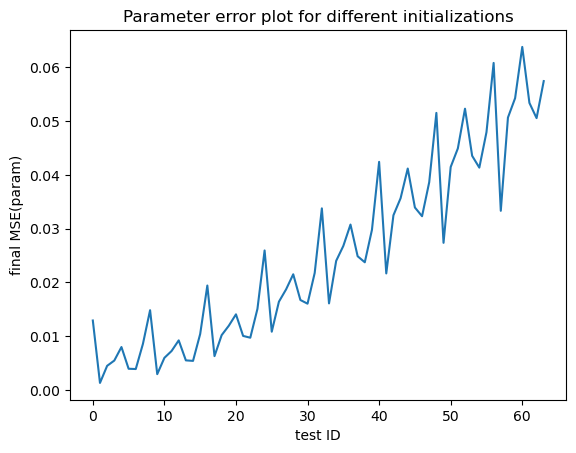

In [6]:
plt.plot(error_grid)
plt.xlabel('test ID'); plt.ylabel('final MSE(param)'); plt.title('Parameter error plot for different initializations');
plt.show()

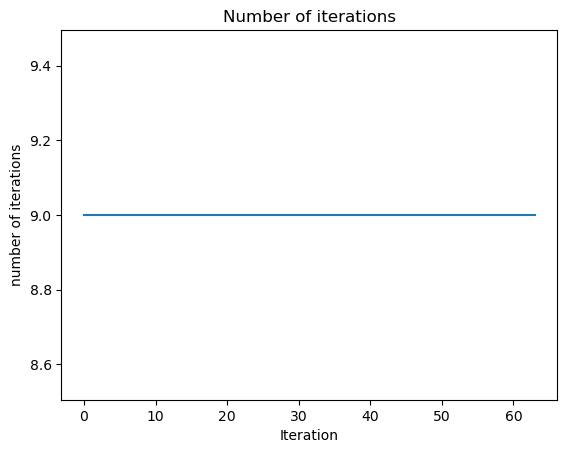

In [7]:
plt.plot(num_iter_converge)
plt.xlabel('Iteration'); 
plt.ylabel('number of iterations'); 
plt.title('Number of iterations');
plt.show()

In [8]:
# Set another color value and update the scene
from gaussnewton_line import conjugate_gradient_line, AlbedoScene_line
params_line[keys[0]] = mi.Color3f(0.01, 0.2, 0.9)
params_line[keys[1]] = mi.Color3f(15, 1, 0.1)

params_line.update();

image_init_line = mi.render(scene, spp=128)
mi.util.convert_to_bitmap(image_init_line)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [9]:
# opt = mi.ad.Adam(lr=0.05)
# opt[key] = params[key]
# params.update(opt);



keys_opt = {'red.reflectance.value', 'light.emitter.radiance.value'} #'green.reflectance.value', 
experiment_idx = -2
sc_line = AlbedoScene_line(scene, params_line,  keys_opt, ref_images = image_ref, _EXP_IDX = experiment_idx)

iteration_count = 10
error_grid = []
num_iter_converge_line = []

for i in range(64):
    id_color_b = i//8
    id_radiance_r = i%8
    # base = i - id_color_g * 64
    # id_color_b = base//16
    # base -= id_color_b * 16
    # id_radiance_r = base//4
    # base -= id_radiance_r
    # id_radiance_g = base%4
    params_line[keys[0]] = mi.Color3f(0.01, 0.2, color_sample[id_color_b])
    params_line[keys[1]] = mi.Color3f(radiance_sample[id_radiance_r], 3, 3)

    params.update();
    
    errors_line = []
    err_ref_init = dr.sum(dr.sqr(param_ref[0] - params_line[keys[0]] + param_ref[1] - params_line[keys[1]]))
    print(f"Test {i:02d}: Initialization parameter error = {err_ref_init[0]:6f}")
    errors_line.append(err_ref_init)
    stop_it = iteration_count

    image, loss = sc.eval_func()
    for it in range(iteration_count):
        
        descent_dir = conjugate_gradient_line(sc_line.values(), loss, sc_line)
        
        sc_line.step(descent_dir)
        
        image, loss = sc_line.eval_func()
        
        # Track the difference between the current color and the true value
        err_ref = dr.sum(dr.sqr(param_ref[0] - params_line[keys[0]] + param_ref[1] - params_line[keys[1]]))
        if err_ref[0] < 1e-3:
            num_iter_converge_line.append(it)
            stop_it = it
            break
        elif it == iteration_count - 1:
            num_iter_converge_line.append(it)
        print(f"Iteration {it:02d}: parameter error = {err_ref[0]:6f}", end='\r')
        errors_line.append(err_ref)
        
    # num_iter_converge.append(iteration_count)
    print('\nOptimization complete.')

    #image_final = mi.render(scene, spp=128)
    #print(params[keys[0]])
    #print(params[keys[1]])
    #mi.util.convert_to_bitmap(image_final)
    error_grid.append(errors[stop_it])
print(error_grid)
print(num_iter_converge_line)

Test 00: Initialization parameter error = 490.711395
l_iter:  0
False
l_iter:  1
False
l_iter:  2
True
l_iter:  000: parameter error = 479.812969
False
l_iter:  1
False
l_iter:  2
True
l_iter:  001: parameter error = 328.776950
False
l_iter:  1
False
l_iter:  2
False
l_iter:  3
True
l_iter:  002: parameter error = 0.090344
False
l_iter:  1
False
l_iter:  2
False
l_iter:  3
True

Optimization complete.
Test 01: Initialization parameter error = 346.675309
l_iter:  0
False
l_iter:  1
False
l_iter:  2
False
l_iter:  3
True
l_iter:  000: parameter error = 0.457306
False
l_iter:  1
False
l_iter:  2
True
l_iter:  001: parameter error = 0.294149
False
l_iter:  1
False
l_iter:  2
False
l_iter:  3
True
l_iter:  002: parameter error = 0.007737
False
l_iter:  1
False
l_iter:  2
False
l_iter:  3
True

Optimization complete.
Test 02: Initialization parameter error = 239.373918
l_iter:  0
False
l_iter:  1
False
l_iter:  2
False
l_iter:  3
True
l_iter:  000: parameter error = 0.305450
False
l_iter:  1

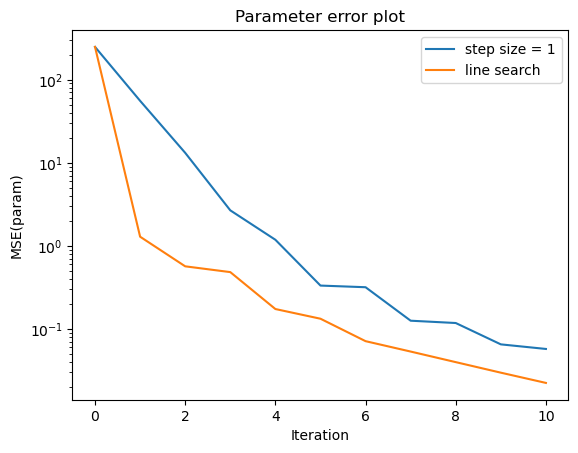

In [12]:
plt.plot(errors, label="step size = 1")
plt.plot(errors_line, label="line search")
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.legend(loc="upper right")
plt.yscale('log')
plt.show()

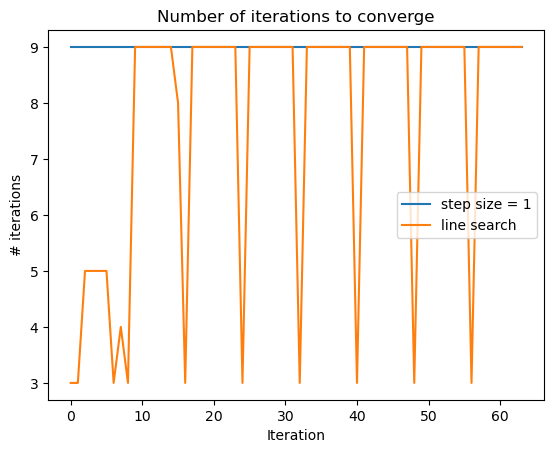

In [15]:
plt.plot(num_iter_converge, label="step size = 1")
plt.plot(num_iter_converge_line, label="line search")
plt.xlabel('Iteration'); plt.ylabel('# iterations'); plt.title('Number of iterations to converge');
#plt.yscale('log')
plt.legend()
plt.show()